Mateusz Łopaciński

# Neural Networks Visualizations

This tutorial is based on the methodologies and findings presented in the paper ['Visualizing the Hidden Activity of Artificial Neural Networks'](https://www.researchgate.net/publication/306049229_Visualizing_the_Hidden_Activity_of_Artificial_Neural_Networks).

- Cyprian Neugebauer
- Mateusz Łopaciński

## 1. Exploring multilayer perceptrons on the EMNIST dataset

The EMNIST dataset is an extension of the original MNIST dataset, including not just digits but also handwritten letters. It offers a broader range of handwriting samples for recognition tasks.
In this mini-tutorial, we'll be using the EMNIST Balanced dataset, chosen for its smaller size compared to the full EMNIST dataset. This ensures an equal representation of all 47 classes (10 digits and 37 letters).

### 1.1 Relevant imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

### 1.2 Load the EMNIST dataset

In [2]:
emnist_train = pd.read_csv("emnist-balanced-train.csv") 
emnist_test = pd.read_csv("emnist-balanced-test.csv")

with open("./emnist-balanced-mapping.txt") as f:
    emnist_classes_mappings = (map(int, line.split()) for line in f.readlines())
    emnist_classes_mappings = {class_id: chr(ascii_num) for class_id, ascii_num in emnist_classes_mappings}

X_emnist_train, y_emnist_train = emnist_train.iloc[:, 1:], emnist_train.iloc[:, 0]
X_emnist_test, y_emnist_test = emnist_test.iloc[:, 1:], emnist_test.iloc[:, 0]

### 1.3 Plot some examples from the dataset

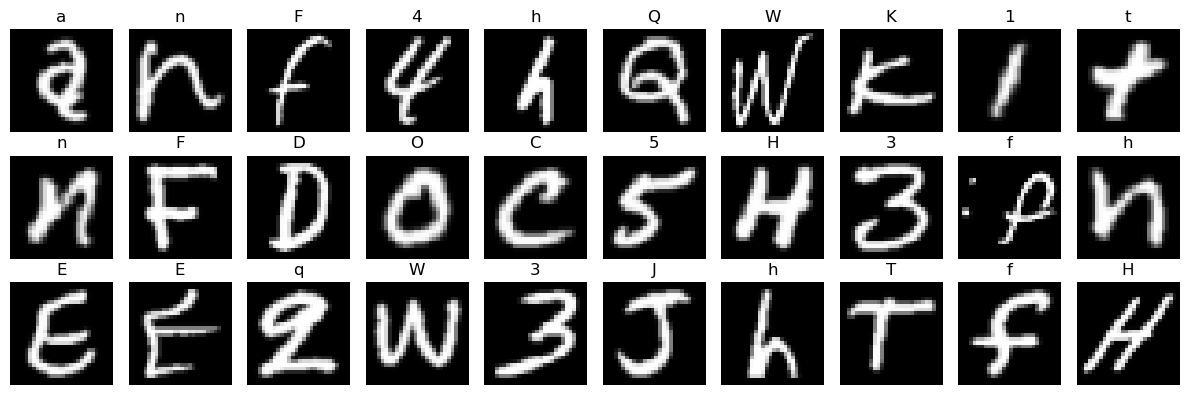

In [3]:
plt.figure(figsize=(12, 4))

for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_emnist_train.iloc[i].to_numpy().reshape(28, 28, order="F"), cmap="gray")
    plt.title(f"{emnist_classes_mappings[y_emnist_train.iloc[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### 1.4 Load the trained MLP model

The model consists of 4 hidden layers with 400 neurons in each layer. 

In [6]:
with open('mlp_emnist.pkl', 'rb') as f:
    mlp_emnist = pickle.load(f)

/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.4.1.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.4.1.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### 1.5 Check the classification report

In [7]:
from sklearn.metrics import classification_report

y_emnist_pred = mlp_emnist.predict(X_emnist_test.to_numpy()).astype(int)

print(classification_report(y_emnist_test, y_emnist_pred))

/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.58      0.74      0.65       400
           1       0.49      0.81      0.61       400
           2       0.86      0.84      0.85       400
           3       0.95      0.94      0.94       400
           4       0.85      0.87      0.86       400
           5       0.91      0.82      0.86       400
           6       0.87      0.89      0.88       400
           7       0.96      0.95      0.95       400
           8       0.85      0.85      0.85       400
           9       0.60      0.75      0.67       400
          10       0.94      0.91      0.92       400
          11       0.86      0.88      0.87       400
          12       0.91      0.91      0.91       400
          13       0.87      0.86      0.87       400
          14       0.94      0.90      0.92       400
          15       0.57      0.58      0.58       400
          16       0.87      0.88      0.87       400
          17       0.93    

The model achieves a decent accuracy of 82%. We didn't fine-tune the model and the training process was kept straightforward. The level of performance is good enough for the purposes of visualization.

### 1.6 Project the activations of neural network

To project the activations to 2 dimensional space we'll use t-SNE, or t-Distributed Stochastic Neighbor Embedding. It is a statistical method for visualizing high-dimensional data by reducing it to two or three dimensions, making it easier to identify patterns, clusters, and outliers visually. t-SNE excels in preserving local relationships and is designed to keep similar data points close together in the reduced space, while dissimilar points are placed further apart.

In [8]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

def layer_projection(layer_activations):
    return tsne.fit_transform(layer_activations)

To extract activations from sklearn's MLPClassifier, we'll need the following utility function. Pass the model instance and the input data as arguments. The function will return the activations from the input layer, all hidden layers, and the output layer.

In [9]:
def get_activations(clf, X):
    hidden_layer_sizes = clf.hidden_layer_sizes
    if not hasattr(hidden_layer_sizes, "__iter__"):
        hidden_layer_sizes = [hidden_layer_sizes]
        
    hidden_layer_sizes = list(hidden_layer_sizes)
    layer_units = [X.shape[1]] + hidden_layer_sizes + [clf.n_outputs_]
    
    activations = [X]
    for i in range(clf.n_layers_ - 1):
        activations.append(np.empty((X.shape[0], layer_units[i + 1])))
        
    return clf._forward_pass(activations)

We measure projection quality by the **neighborhood
hit (NH)**, which indicates how well classes are visually separated.\
For a given $k$, the NH for a point $a_p$ is the ratio
of its k-nearest neighbors that belong to the same class as $a_p$.\
The NH for a whole projection is the average NH over its points.

In [10]:
from sklearn.neighbors import NearestNeighbors

k=6
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree')

def get_nh_score(layer_projection, y_test):
    y_test = y_test.to_numpy()
    
    nbrs.fit(layer_projection)
    distances, indices = nbrs.kneighbors(layer_projection)
    
    nh_score = 0
    for i in range(len(layer_projection)):
        neighbor_idx = indices[i]
        
        same_label_count = sum(y_test[neighbor_idx] == y_test[i])
        
        nh_score += same_label_count / k
    
    return nh_score / len(layer_projection)

Activations for a given layer, the subject of our analysis, are extracted
for a random subset of 1000 observations from the test set, strictly
to facilitate visual presentation. 

In [11]:
random_1000_X_emnist_test = X_emnist_test.sample(n=1000, random_state=42)
random_1000_y_emnist_test = y_emnist_test.loc[random_1000_X_emnist_test.index]

activations = get_activations(mlp_emnist, random_1000_X_emnist_test.to_numpy())

#### Project the EMNIST test dataset



In [12]:
X_emnist_test_projection = layer_projection(activations[0])

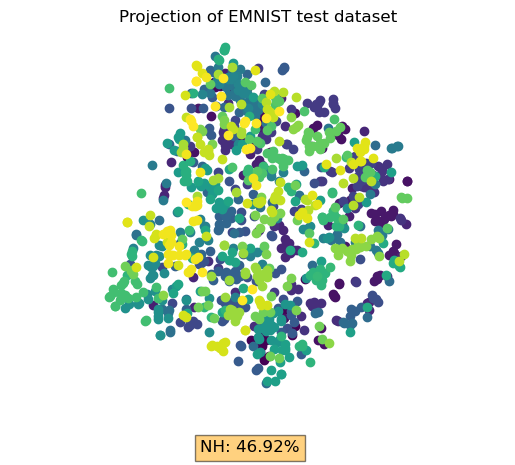

In [13]:
plt.figure()

classes = np.unique(y_emnist_test)
cmap = plt.get_cmap('viridis', len(classes))

for j, cls in enumerate(classes):
    ix = np.where(random_1000_y_emnist_test == cls)
    plt.scatter(X_emnist_test_projection[ix, 0], X_emnist_test_projection[ix, 1], c=[cmap(j)], label=cls)
    plt.axis("off")
    plt.axis("equal")

nh_score = get_nh_score(X_emnist_test_projection, random_1000_y_emnist_test)

plt.title("Projection of EMNIST test dataset")
plt.figtext(0.5, 0.001, f'NH: {nh_score * 100:.2f}%', ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad": 4})
plt.show()

The separability of classes within the test dataset after projection is quite poor, as confirmed by the Nearest Neighbor (NH) score.

Let's now plot and compare projections of activations in hidden layers.

In [14]:
import matplotlib.patches as mpatches

def plot_layer_projection(layers_projections, y_test, plot_legend=True):
    classes = np.unique(y_test)
    
    num_plots = len(layers_projections)
    num_rows = num_plots // 4
    
    fig, axs = plt.subplots(num_rows, 4, figsize=(20, 7 * num_rows))
    fig.suptitle("Activation projection", fontweight="bold")
    
    if num_plots <= 4:
        axs = [axs]

    cmap = plt.get_cmap('viridis', len(classes))
    
    for i, layer_projection in enumerate(layers_projections):
        row, col = divmod(i, 4)
        ax = axs[row][col]
        
        for j, cls in enumerate(classes):
            ix = np.where(y_test == cls)
            ax.scatter(layer_projection[ix, 0], layer_projection[ix, 1], c=[cmap(j)], label=cls)

        nh_score = get_nh_score(layer_projection, y_test)
        ax.text(0.5, -0.2, f'NH: {nh_score * 100:.2f}%', transform=ax.transAxes, ha='center', va='top', fontsize=14, bbox={"facecolor":"orange", "alpha":0.5, "pad": 4})
        ax.set_title(f"Hidden Layer {i + 1}")
        ax.axis("off")
        ax.axis('equal')

    for j in range(i + 1, num_rows * 4):
        row, col = divmod(j, 4)
        axs[row][col].axis('off')

    if plot_legend:
        legend_patches = [mpatches.Patch(color=cmap(i), label=cls) for i, cls in enumerate(classes)]
        fig.legend(handles=legend_patches, loc='upper center', ncol=len(classes), bbox_to_anchor=(0.5, 1.05))

    plt.tight_layout()
    plt.show()

#### Before training

In [15]:
from sklearn.neural_network import MLPClassifier

untrained_mlp_emnist = MLPClassifier(hidden_layer_sizes=(300, 300, 300, 300), max_iter=1)
untrained_mlp_emnist.fit(X_emnist_train.iloc[0:1], y_emnist_train.iloc[0:1])

pretraining_activations = get_activations(untrained_mlp_emnist, random_1000_X_emnist_test.to_numpy())

/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


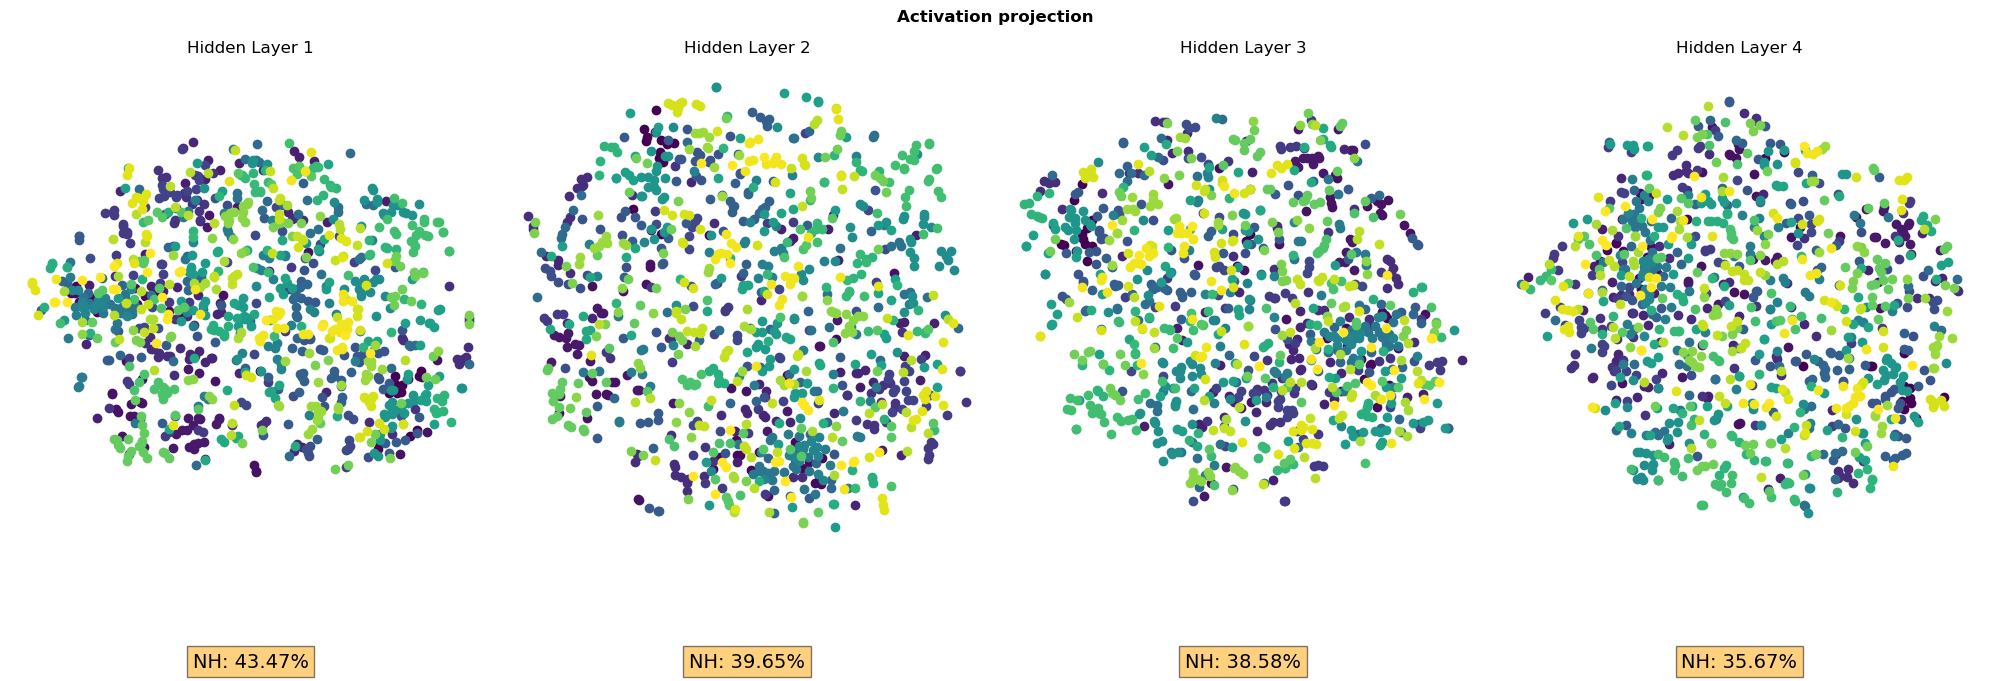

In [16]:
pretraining_layers_projections = list(map(layer_projection, pretraining_activations[1:-1]))
plot_layer_projection(pretraining_layers_projections, random_1000_y_emnist_test, plot_legend=False)

The representation of input data in each layer (activations) does not result in distinguishable visual clusters when tested on an untrained Multilayer Perceptron (MLP).
NH score is getting worse and worse in hidden layers, it proves that MLP is untrained and random transformations are performed.

#### After training

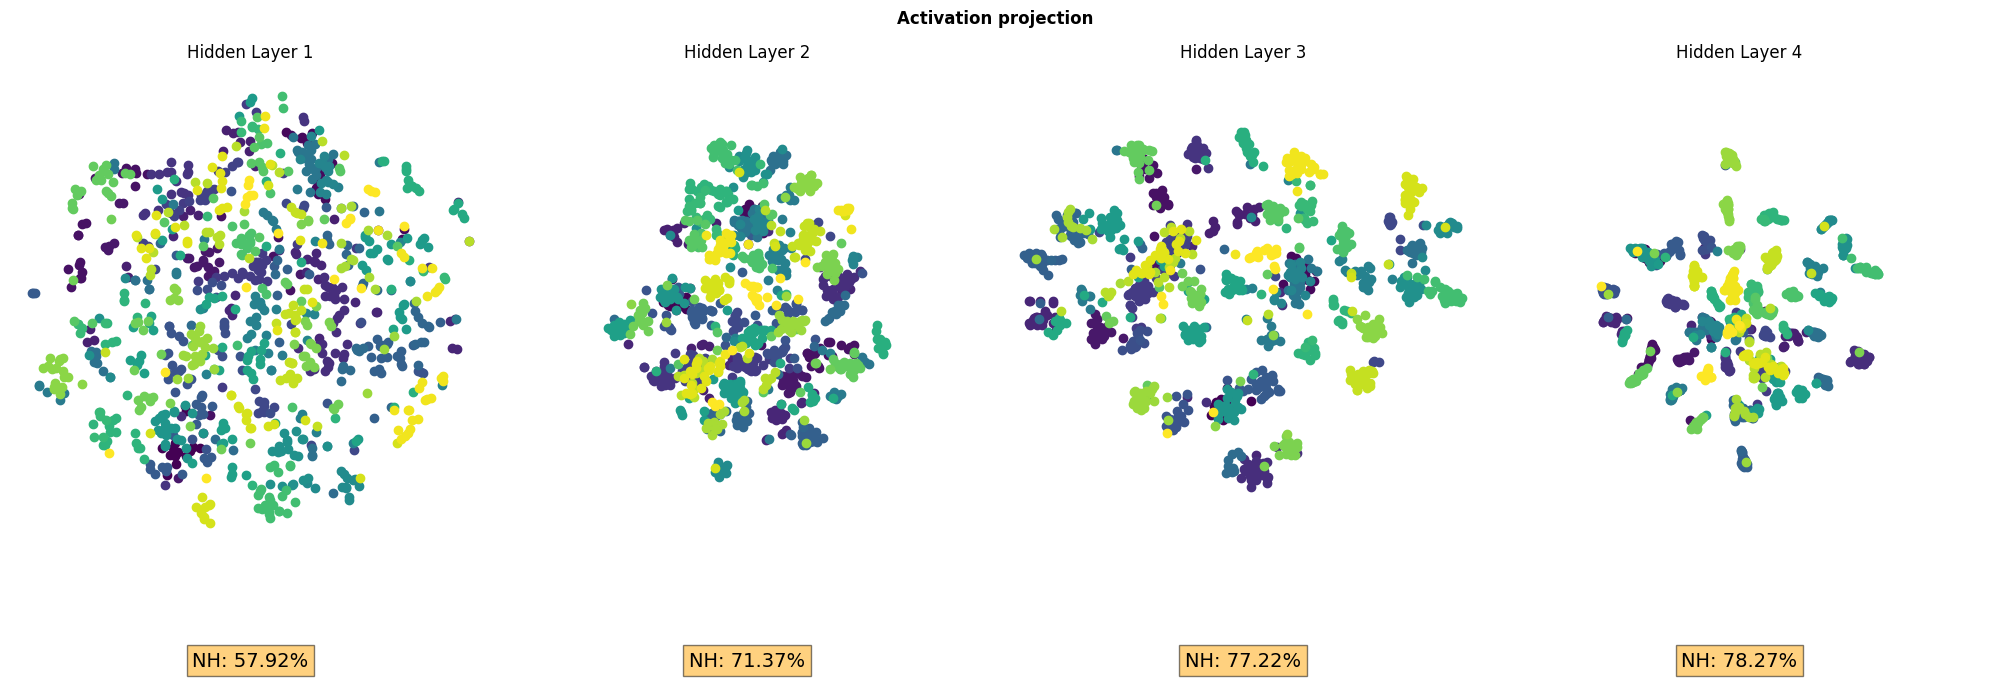

In [ ]:
layers_projections = list(map(layer_projection, activations[1:-1]))
plot_layer_projection(layers_projections, random_1000_y_emnist_test, plot_legend=False)

On the other hand, with a trained Multilayer Perceptron (MLP), the results are significantly improved, as visually distinct clusters become apparent, especially in the last hidden layer.

### 1.7 Project the neurons

From the matrix of pairwise dissimilarities, we
compute a projection using (absolute metric) multidimensional scaling (MDS). While t-SNE is particularly concerned with preserving neighborhood relationships, absolute metric MDS attempts to
preserve global pairwise dissimilarities as well as possible, which
is more appropriate in this scenario. As we confirmed through preliminary experiments, MDS presents more coherent relationships between
neurons that are discriminative for a particular class, which is important for a neuron projection\
\
We next color each point (neuron) based on its ability to discriminate between class 0 and all other
classes, computed by a standard feature selection technique, based on
extremely randomized trees.

In [17]:
from sklearn.manifold import MDS
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()
mds = MDS(n_components=2, dissimilarity="precomputed")

def neurons_projection(layer_activations, y_labels):
    clf.fit(layer_activations, y_labels)

    correlation_matrix = np.nan_to_num(np.corrcoef(layer_activations, rowvar=False))

    dissimilarities = 1 - np.abs(correlation_matrix)
    
    return mds.fit_transform(dissimilarities), clf.feature_importances_

In [18]:
def plot_neuron_projection(neurons_projections, neurons_importances, cls):
    num_plots = len(neurons_projections)
    num_rows = num_plots // 4
    
    fig, axs = plt.subplots(num_rows, 4, figsize=(20, 7 * num_rows))
    fig.suptitle(f"Neuron projection - discriminative power ({cls} vs rest)", fontweight="bold")
    
    if num_plots <= 4:
        axs = [axs]
    
    for i, (neuron_projection, neuron_importances) in enumerate(zip(neurons_projections, neurons_importances)):
        row, col = divmod(i, 4)
        ax = axs[row][col]
        
        scatter = ax.scatter(neuron_projection[:, 0], neuron_projection[:, 1], c=neuron_importances, cmap="Reds")
        
        cbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', shrink=0.6, pad=0.1)
        cbar.set_ticks([neuron_importances.min(), neuron_importances.max()])
        cbar.set_ticklabels(['Low', 'High'])

        ax.set_title(f"Hidden Layer {i + 1}")
        ax.axis("off")
        ax.axis('equal')

    for j in range(i + 1, num_rows * 4):
        row, col = divmod(j, 4)
        axs[row][col].axis('off')

    plt.tight_layout()
    plt.show()

We correlate the results of the neurons projections with the saturation in a given layer.\
Saturation refers to a state where a neuron's output is near its maximum or minimum value, causing it to become less sensitive to changes in its input. Saturation with ReLU activation function, which we use in our MLP can happen when output of neuron is 0 or very close to 0.

In [19]:
def plot_layers_saturation(layers_activations):
    n_layers = len(layers_activations)
    n_rows = n_layers // 4
    
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    
    for i, activation in enumerate(layers_activations):
        ax = axes[i]
        ax.hist(activation.ravel(), bins=30)
        ax.set_title(f'Layer {i + 1} Activation Distribution')
        ax.set_xlabel('Activation Value')
        ax.set_ylabel('Frequency')
        
        dead_neurons_percent = np.mean(activation == 0) * 100
        ax.text(0.5, -0.2, f'{dead_neurons_percent:.2f}% dead neurons', 
                transform=ax.transAxes, ha='center', va='top', fontsize=14, bbox={"facecolor":"orange", "alpha":0.5, "pad": 4})
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [20]:
pretraining_neurons_projections = list(map(lambda x: neurons_projection(x, random_1000_y_emnist_test == 0), pretraining_activations[1:-1]))
pretraining_neurons_projections, pretraining_neurons_importances = list(zip(*pretraining_neurons_projections))

/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/numpy/lib/function_base.py:

In [21]:
neurons_projections = list(map(lambda x: neurons_projection(x, random_1000_y_emnist_test == 0), activations[1:-1]))
neurons_projections, neurons_importances = list(zip(*neurons_projections))

/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/mateu/miniconda3/envs

#### Before training

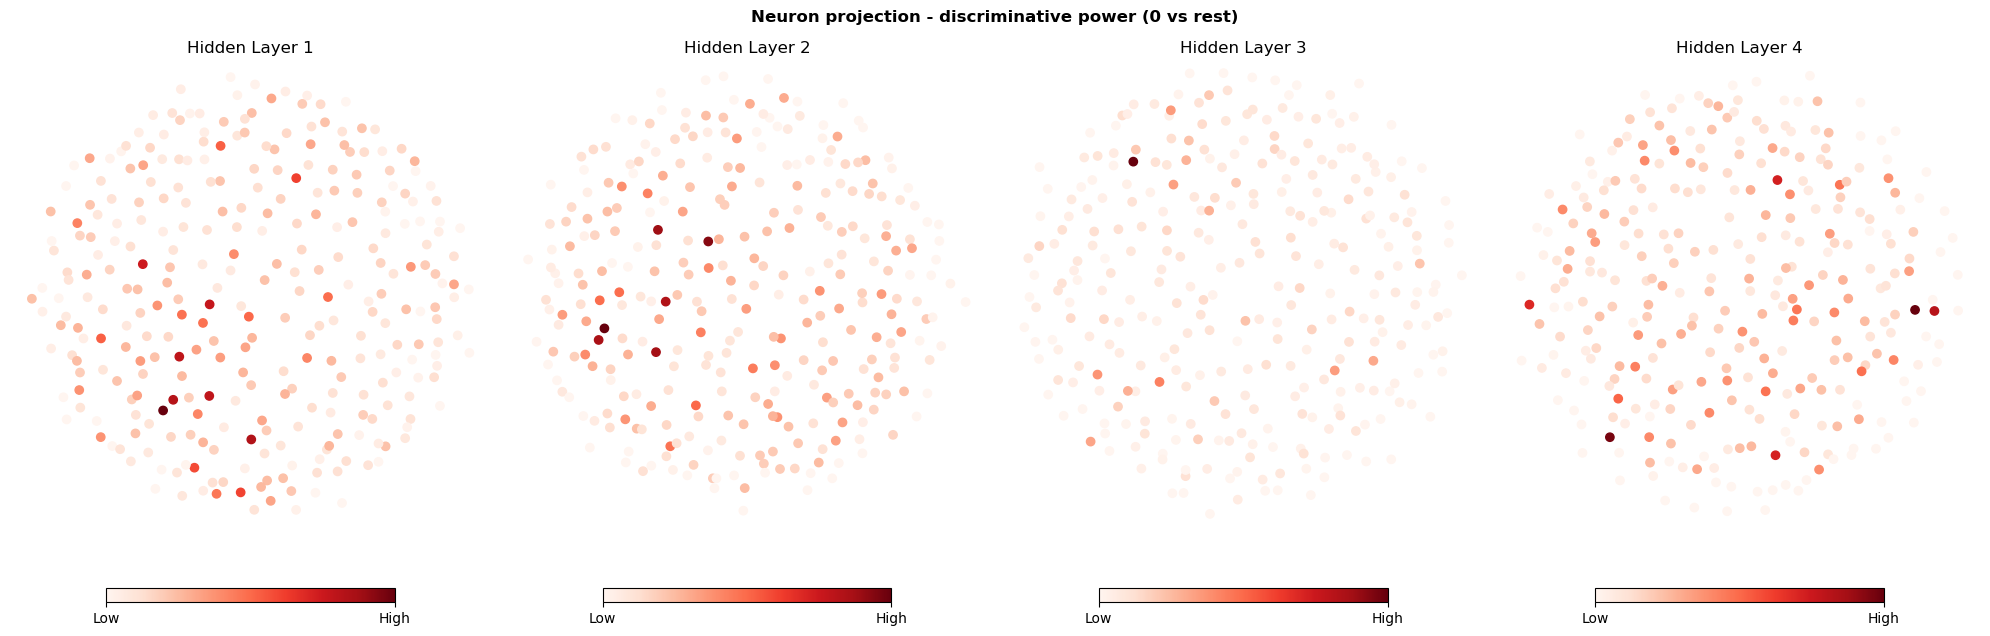

In [22]:
plot_neuron_projection(pretraining_neurons_projections, pretraining_neurons_importances, cls=0)

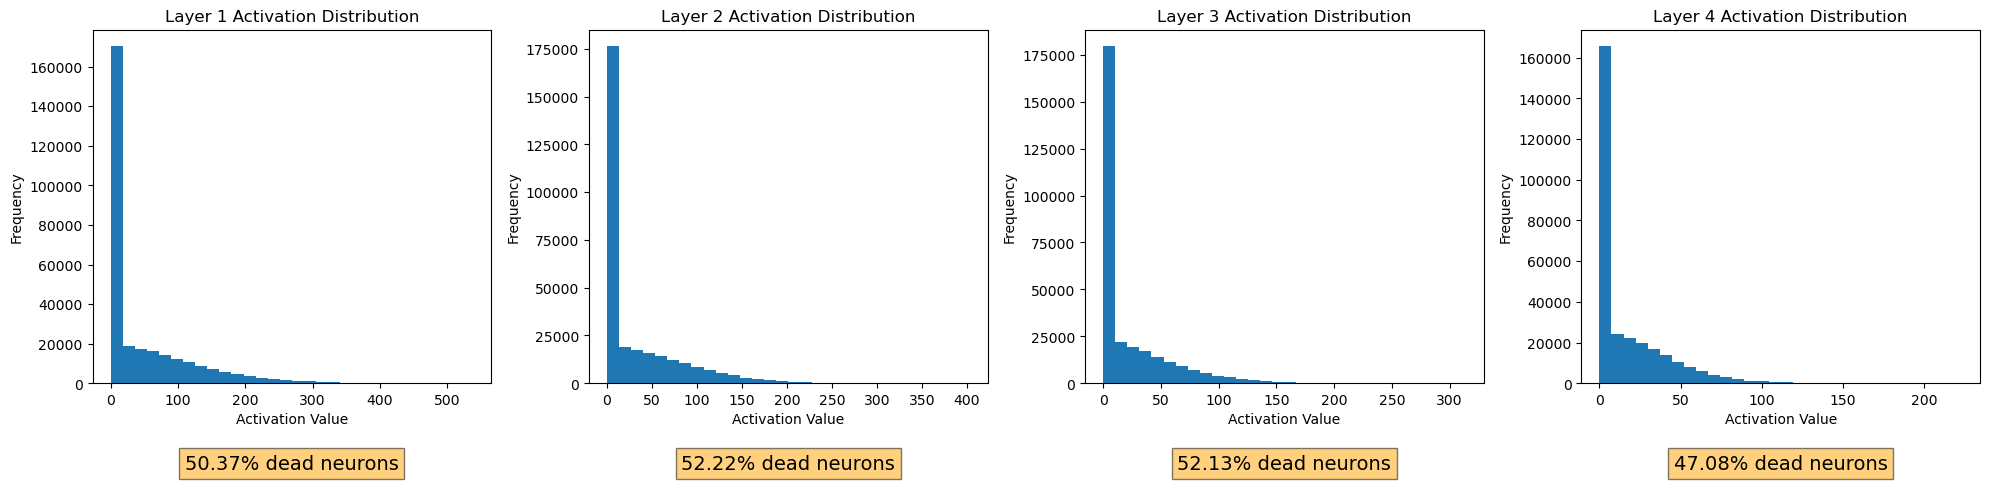

In [23]:
plot_layers_saturation(pretraining_activations[1:-1])

We observe that random neurons are active, which is an expected condition in an untrained Multilayer Perceptron (MLP).

#### After training

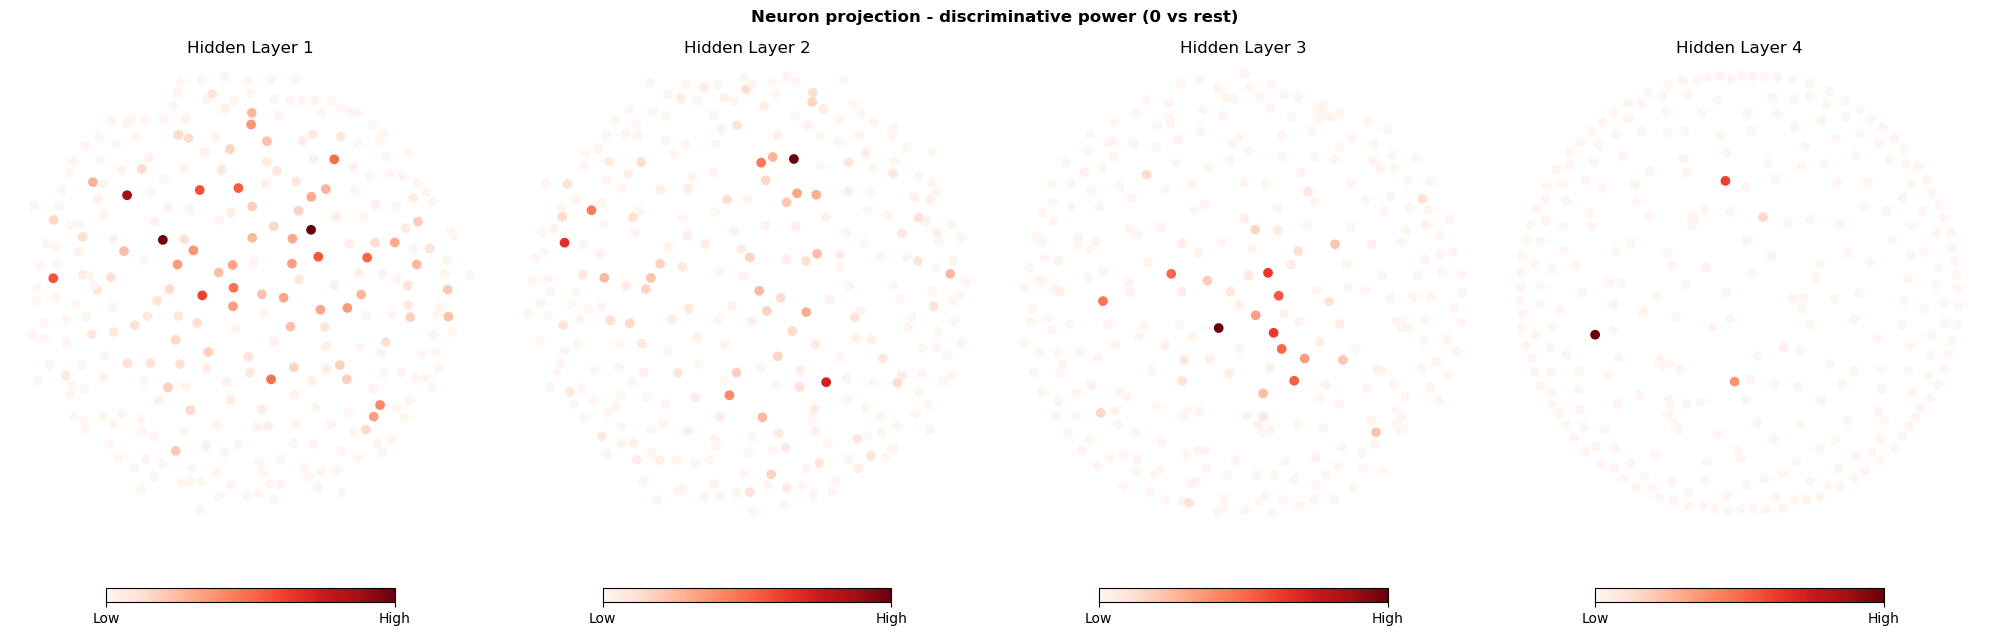

In [24]:
plot_neuron_projection(neurons_projections, neurons_importances, cls=0)

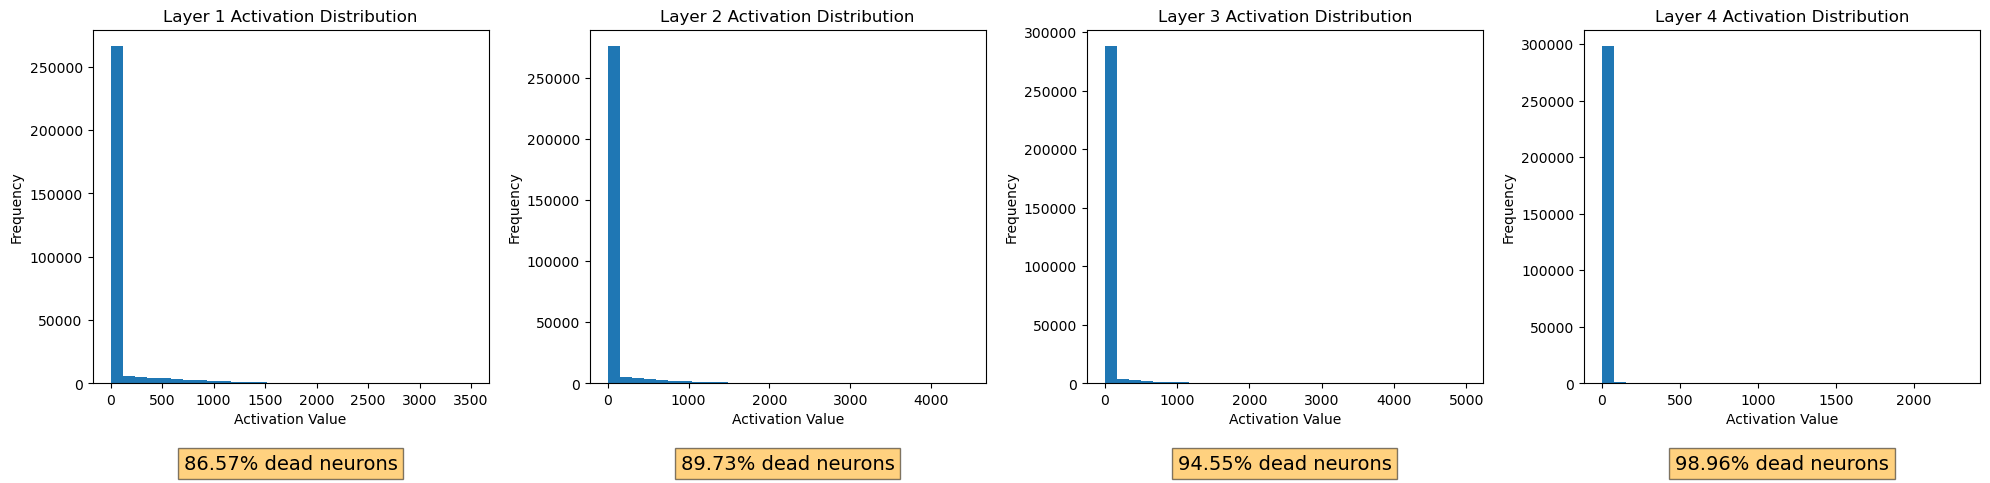

In [25]:
plot_layers_saturation(activations[1:-1])

After training, only a small subset of neurons remains active, specifically those neurons that are responsible for predicting class 0.

### 1.8 Exercise

As an exercise we'll prune some neurons and see how does it affect our visualizations.

In [27]:
with open('mlp_emnist_2024-04-07_22_40_21.466815.pkl', 'rb') as f:
    mlp_emnist_copy = pickle.load(f)

/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.4.1.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mateu/miniconda3/envs/py_3_11/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.4.1.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


For each layer prune the most active neurons in class 0 prediction.\
The most active neurons in given layer are the neurons with importances greater than `NEURON_IMPORTANCE_THRESHOLD`.\
For that neurons set coefficients (weights) to 0.

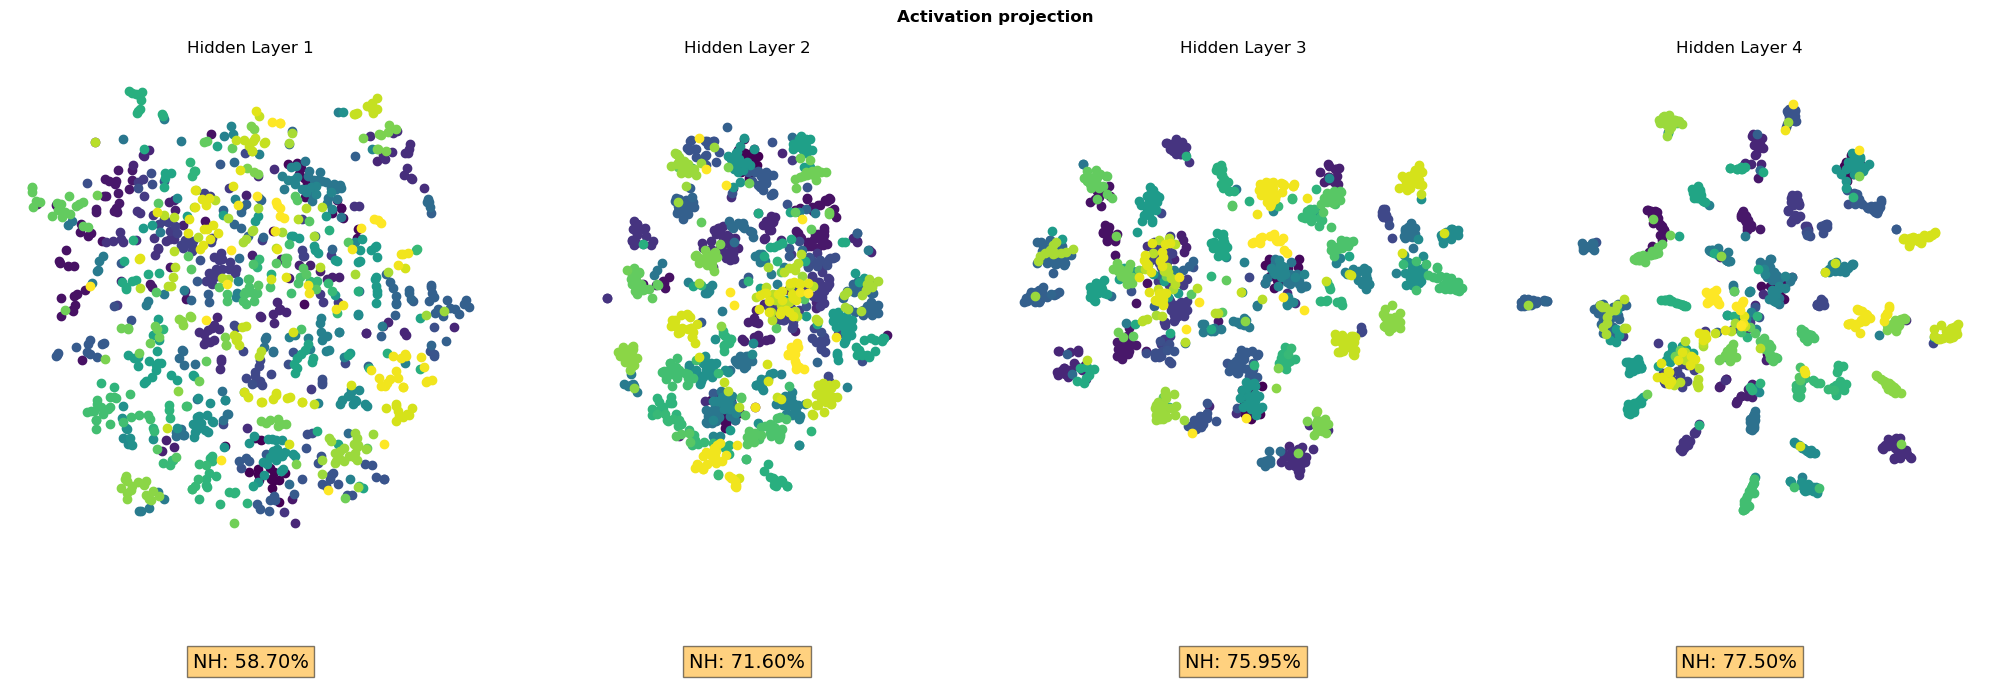

In [28]:
# E.g to set the coefficients of first layer and first neuron to 0 you can use mlp_emnist_copy.coefs_[0][:, 0] = 0

NEURON_IMPORTANCE_THRESHOLD = 0.025

for layer_idx in range(4):
    # Get the important neurons using neurons_importances and NEURON_IMPORTANCE_THRESHOLD
    important_neurons = np.where(neurons_importances[layer_idx] > NEURON_IMPORTANCE_THRESHOLD)[0]
    mlp_emnist_copy.coefs_[layer_idx][:, ~important_neurons] = 0

activations_after_neuron_pruning = get_activations(mlp_emnist_copy, random_1000_X_emnist_test.to_numpy())
layers_projections_after_neuron_pruning = list(map(layer_projection, activations_after_neuron_pruning[1:-1]))
plot_layer_projection(layers_projections_after_neuron_pruning, random_1000_y_emnist_test, plot_legend=False)

Let's prune half of neurons in each layer and see what happens. 

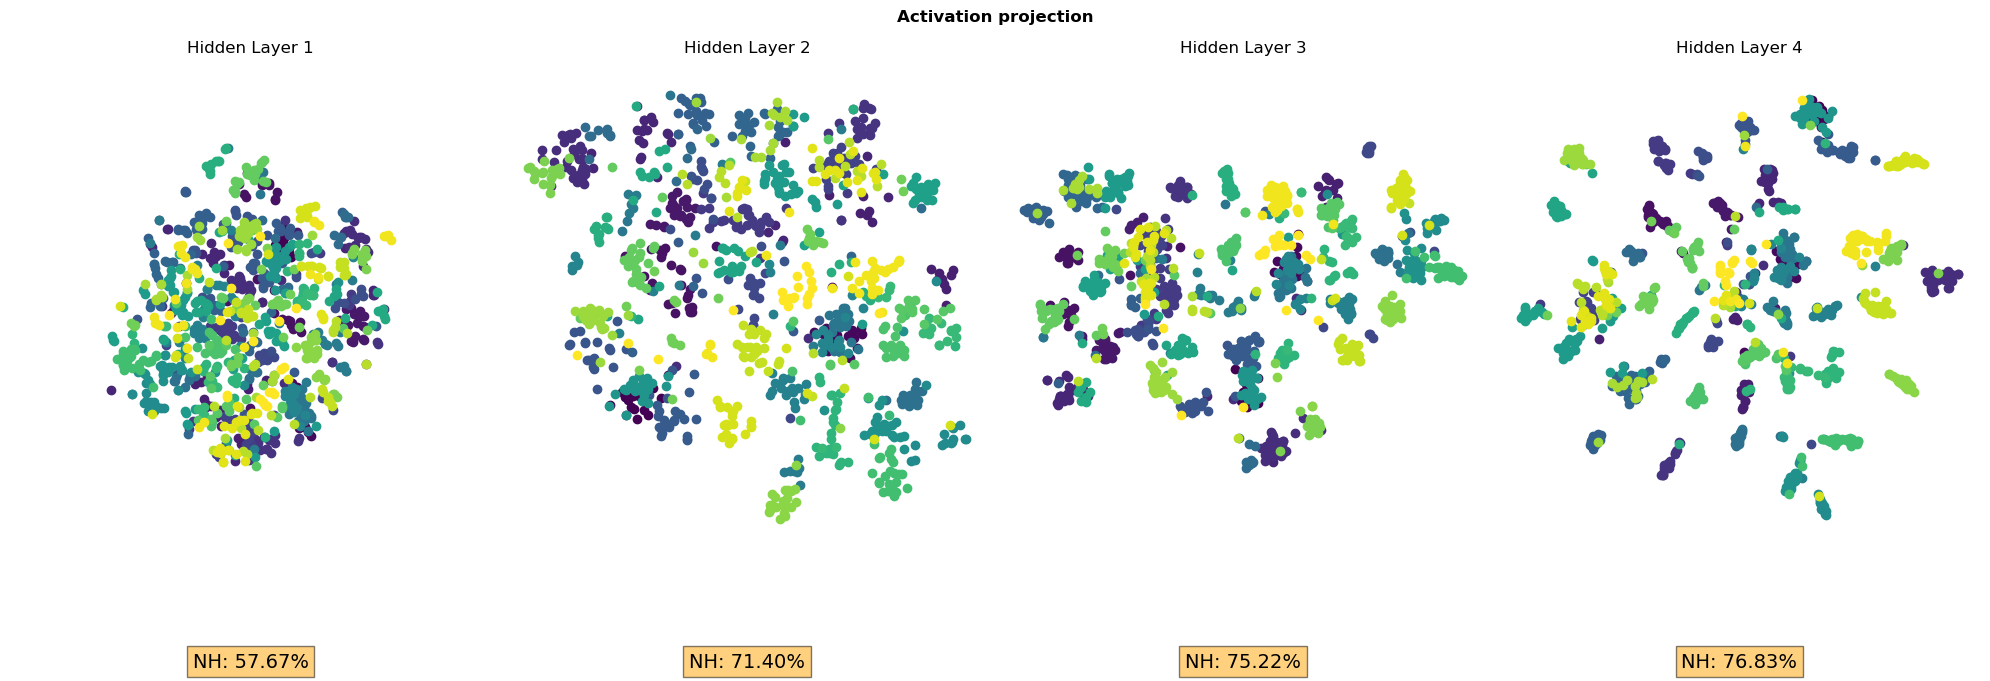

In [29]:
for layer_idx in range(4):
    # Set coefficients of current layer to 0 for first half of neurons
    mlp_emnist_copy.coefs_[layer_idx][:, :len(important_neurons) // 2] = 0
    
activations_after_neuron_pruning = get_activations(mlp_emnist_copy, random_1000_X_emnist_test.to_numpy())
layers_projections_after_neuron_pruning = list(map(layer_projection, activations_after_neuron_pruning[1:-1]))
plot_layer_projection(layers_projections_after_neuron_pruning, random_1000_y_emnist_test, plot_legend=False)